In [2]:
import os
import random
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import cv2
from IPython.display import Image
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model

In [3]:
## Define the image attributes
FAST_RUN=False
IMAGE_WIDTH = 224 
IMAGE_HEIGHT = 224
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3

In [4]:
## Filepath for the training dataset
filenames = os.listdir(r"C:/Users/dhrupad/Desktop/EGEE-529/Project/Dataset/train/train1")
labels = []

In [5]:
## Split the files into 'good' and 'bad' and make two classes
for filename in filenames:
    label = filename.split(' ')[0]
    if label == 'good':
        labels.append(0)
    else:
        labels.append(1)

df = pd.DataFrame({
    'filename': filenames,
    'label': labels
})

df.head(1000)

,filename,label
0,bad (1)k.jpeg,1
1,bad (10)k.jpeg,1
2,bad (100)k.jpeg,1
3,bad (101)k.jpeg,1
4,bad (102)k.jpeg,1
...,...,...
995,good (522)k.jpeg,0
996,good (523)k.jpeg,0
997,good (524)k.jpeg,0
998,good (525)k.jpeg,0


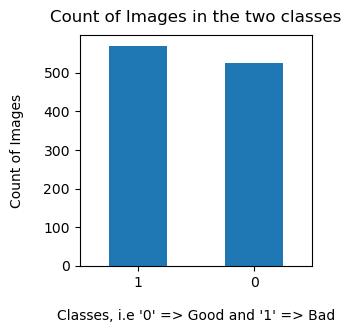

In [6]:
## Plot the number of files identified in a bar plot
df['label'].value_counts().plot(kind='bar',figsize=(3, 3), rot=0)
plt.xlabel("Classes, i.e '0' => Good and '1' => Bad", labelpad=14)
plt.ylabel("Count of Images", labelpad=14)
plt.title("Count of Images in the two classes", y=1.02);

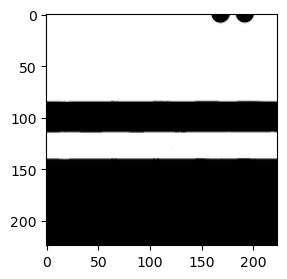

In [7]:
## Test if the algorithm is able to pick up a sample image
sample = random.choice(filenames)
plt.figure(figsize=(3, 3))
plt.tight_layout()
image = load_img(r"C:/Users/dhrupad/Desktop/EGEE-529/Project/Dataset/train/train1/"+sample)
plt.imshow(image)

In [8]:
## Define the Network
model_base = MobileNet (weights = 'imagenet', include_top = False)    # Import the MobileNet algorithm, and discard the top layers

x = model_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024,activation='relu')(x)                                  # Add Dense layer 1
x = Dense(1024,activation='relu')(x)                                  # Add Dense layer 2
x = Dense(512,activation='relu')(x)                                   # Add Dense layer 3
pred = Dense(2,activation='softmax')(x) 

17225924/17225924 [==============================] - 0s 0us/step


In [9]:
## Define model input, output and optimization metrics
model = Model(inputs = model_base.input, outputs = pred)

model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 

for layer in model.layers[:20]:
    layer.trainable = False
for layer in model.layers[20:]:
    layer.trainable = True

earlystop = EarlyStopping(patience = 10)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

df["label"] = df["label"].replace({0: 'Good', 1: 'Bad'}) 

train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [10]:
## Define the training data
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size = 15

train_datagen = ImageDataGenerator(
    rotation_range = 15,
    rescale = 1./255,
    shear_range = 0.1,
    zoom_range = 0.2,
    horizontal_flip = True,
    width_shift_range = 0.1,
    height_shift_range = 0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, r"C:/Users/dhrupad/Desktop/EGEE-529/Project/Dataset/train/train1", 
    x_col = 'filename',
    y_col = 'label',
    target_size = IMAGE_SIZE,
    class_mode = 'categorical',
    batch_size = batch_size
)

Found 876 validated image filenames belonging to 2 classes.


In [11]:
## Validate the training data
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, r"C:/Users/dhrupad/Desktop/EGEE-529/Project/Dataset/train/train1", 
    x_col = 'filename',
    y_col = 'label',
    target_size = IMAGE_SIZE,
    class_mode = 'categorical',
    batch_size = batch_size
)

Found 219 validated image filenames belonging to 2 classes.


In [12]:
## Start the Training
epochs=3 if FAST_RUN else 5
history = model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/5
58/58 [==============================] - 55s 855ms/step - loss: 0.7058 - accuracy: 0.6806 - val_loss: 0.5331 - val_accuracy: 0.8286 - lr: 0.0010
Epoch 2/5
58/58 [==============================] - 48s 819ms/step - loss: 0.3047 - accuracy: 0.8990 - val_loss: 0.4658 - val_accuracy: 0.9143 - lr: 0.0010
Epoch 3/5
58/58 [==============================] - 48s 822ms/step - loss: 0.2138 - accuracy: 0.9373 - val_loss: 0.4158 - val_accuracy: 0.9190 - lr: 0.0010
Epoch 4/5
58/58 [==============================] - 47s 817ms/step - loss: 0.2192 - accuracy: 0.9210 - val_loss: 0.4062 - val_accuracy: 0.9238 - lr: 0.0010
Epoch 5/5
58/58 [==============================] - 48s 823ms/step - loss: 0.1803 - accuracy: 0.9419 - val_loss: 0.2432 - val_accuracy: 0.9429 - lr: 0.0010


In [13]:
## Save the Model
model.save("model.h5")

In [14]:
model.save("C:/Users/dhrupad/Desktop/EGEE-529/Project")

INFO:tensorflow:Assets written to: C:/Users/dhrupad/Desktop/EGEE-529/Project\assets


INFO:tensorflow:Assets written to: C:/Users/dhrupad/Desktop/EGEE-529/Project\assets


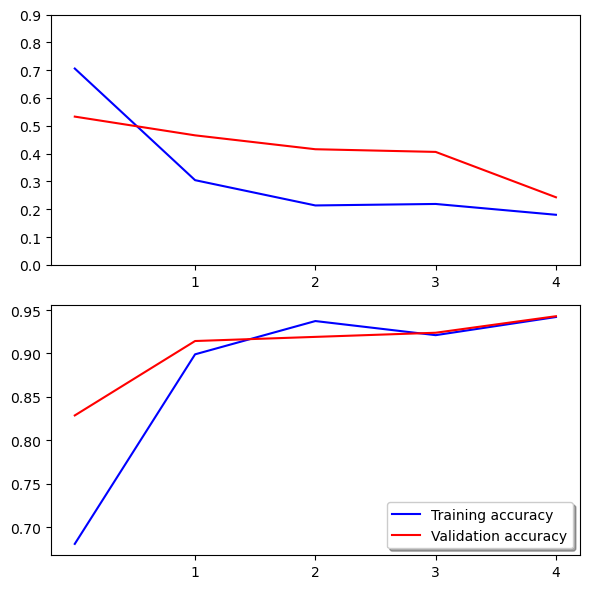

In [20]:
## Plotting the data model data
## Plot Number 1 : Training Loss vs. Validation Loss
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

## Plot Number 2 : Training Accuracy vs. Validation Accuracy
ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [16]:
## Load Model
model = load_model(r"C:/Users/dhrupad/Desktop/EGEE-529/Project/model.h5")

In [17]:
import cv2
img = cv2.imread(r"C:/Users/dhrupad/Desktop/EGEE-529/Project/Dataset/test/test1/good (371)k.jpeg")
img = img[...,::-1]
model.predict(img[None,...], batch_size=None, verbose=2, steps=1)

1/1 - 0s - 345ms/epoch - 345ms/step


array([[9.9973351e-01, 2.6643238e-04]], dtype=float32)

In [18]:
## Test Model
test_filenames = os.listdir(r"C:/Users/dhrupad/Desktop/EGEE-529/Project/Dataset/test/test1/")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    r"C:/Users/dhrupad/Desktop/EGEE-529/Project/Dataset/test/test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

predict = model.predict(test_generator, steps=np.ceil(nb_samples/batch_size))

test_df['label'] = np.argmax(predict, axis=-1)

label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['label'] = test_df['label'].replace(label_map)

Found 100 validated image filenames.
7/7 [==============================] - 2s 198ms/step


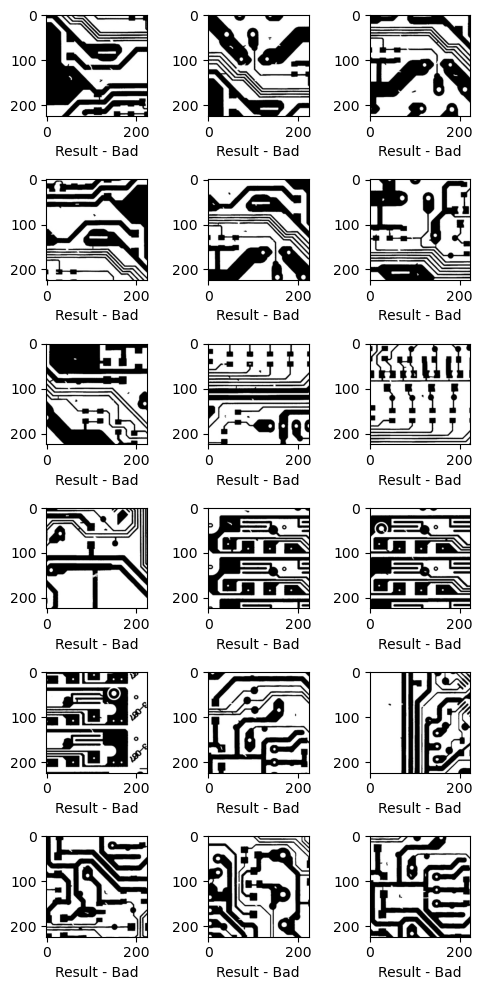

In [19]:
## Sample Testing
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(5, 10))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['label']
    img = load_img(r"C:/Users/dhrupad/Desktop/EGEE-529/Project/Dataset/test/test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel('Result - ' + "{}".format(category))
plt.tight_layout()
plt.show()